In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from prepare import *
from catboost import CatBoostRegressor, Pool
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from metrics import *

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

In [3]:
def evaluate(model, X, y):
    preds = model.predict(X)

    res = np.clip(preds, 0 , 3000)
    #print("Y ", y, "\nPreds ", invert(preds))
    print("MSE: " + str(mean_squared_error(res, y)))
    print("SMAPE: " + str(smape(res, y)))

In [4]:
data = pd.read_csv("../data/train.csv")

In [5]:
data['Average price'] = data.apply(lambda x : averagePrice(x), axis=1).astype(float)
data.fillna('Nan', inplace=True)

y = data["Sales"]
X = data.drop(columns=["Sales"])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

Name  \
3214           Массажер электрический OVAL/вибромассажер   
8203    Воздухонагреватель электрический RedVerg RD-EHC3   
13925  Фреза для маникюра для снятия старого покрытия...   
18650                 Антимоскитный светильник LED 3 Вт.   
10806  Массажная роликовая подушка с ИК - прогревом и...   

                                                Category         Brand  \
3214   /Красота и здоровье/Массажеры электрические/Ма...   Juliabeauty   
8203   /Климатическая техника/Обогрев помещения/Тепло...       RedVerg   
13925  /Красота и здоровье/Косметические аппараты/Фре...       HDFREZA   
18650                /Садовая техника/Лампы от насекомых       Ergolux   
10806  /Красота и здоровье/Массажеры электрические/Ма...  Healthy Life   

                                   Seller Color  Comments  Final price  \
3214   Калашников Андрей Александрович ИП   Nan      24.0       1890.0   
8203                      ТМК ОПТТОРГ ООО   Nan       7.0       2689.0   
13925  Мыслицкий Владимир Вячеславович ИП   Nan       3.0        149.0   
18650       Энергосистемы и Технологии АО   Nan       0.0        549.0   
10806                     КМД-ПАРТНЁР ООО   Nan       1.0       2286.0   

       Max price  Min price  Average price  Days in stock  Days with sales  \
3214      1890.0     1890.0    1890.000000           31.0               29   
8203      2689.0     2372.0    2445.333333            7.0                8   
13925      149.0      149.0     149.000000           17.0                8   
18650      549.0      549.0     549.000000           31.0                0   
10806     2378.0     2012.0    2231.600000           15.0                4   

       Rating  Basic Sale  Basic Sale Price  Base price  \
3214   5,0000        55.0            2520.0      5600.0   
8203   5,0000        35.0            2689.0      4138.0   
13925  5,0000         0.0             149.0       149.0   
18650  0,0000        50.0             549.0      1098.0   
10806  5,0000        50.0            2286.0      4573.0   

                                           full_category  
3214   Бытовая техника/Красота и здоровье/Массажеры э...  
8203   Бытовая техника/Климатическая техника/Обогрев ...  
13925  Бытовая техника/Красота и здоровье/Косметическ...  
18650  Бытовая техника/Садовая техника/Лампы от насек...  
10806  Бытовая техника/Красота и здоровье/Массажеры э...

In [7]:
cat_features = np.where(X_train.loc[:, X_train.columns.values].dtypes == "object")[0]
# sanity check
X_train.iloc[:, cat_features]

Name  \
3214           Массажер электрический OVAL/вибромассажер   
8203    Воздухонагреватель электрический RedVerg RD-EHC3   
13925  Фреза для маникюра для снятия старого покрытия...   
18650                 Антимоскитный светильник LED 3 Вт.   
10806  Массажная роликовая подушка с ИК - прогревом и...   
...                                                  ...   
21575                                Увлажнитель MT-2370   
5390   Пульт дистанционного управления для приемников...   
860                                                 Утюг   
15795                                      Пульсоксиметр   
23654  Пульт Huayu RC1910 для телевизоров Sharp и Tos...   

                                                Category         Brand  \
3214   /Красота и здоровье/Массажеры электрические/Ма...   Juliabeauty   
8203   /Климатическая техника/Обогрев помещения/Тепло...       RedVerg   
13925  /Красота и здоровье/Косметические аппараты/Фре...       HDFREZA   
18650                /Садовая техника/Лампы от насекомых       Ergolux   
10806  /Красота и здоровье/Массажеры электрические/Ма...  Healthy Life   
...                                                  ...           ...   
21575                                  /Техника для дома         Marta   
5390   /Техника для дома/Пульты управления/Пульты тел...        CADENA   
860         /Техника для дома/Утюги и отпариватели/Утюги       Endever   
15795  /Красота и здоровье/Медицинские приборы/Пульсо...    MEDICINECA   
23654  /Техника для дома/Пульты управления/Пульты тел...         HUAYU   

                                   Seller Color  Rating  \
3214   Калашников Андрей Александрович ИП   Nan  5,0000   
8203                      ТМК ОПТТОРГ ООО   Nan  5,0000   
13925  Мыслицкий Владимир Вячеславович ИП   Nan  5,0000   
18650       Энергосистемы и Технологии АО   Nan  0,0000   
10806                     КМД-ПАРТНЁР ООО   Nan  5,0000   
...                                   ...   ...     ...   
21575                         ВАЛЕРИЯ ООО   Nan  3,0000   
5390                    ООО СПУТНИК ТРЕЙД   Nan  2,0000   
860                          ВЛКГРУПП ООО   Nan  3,0000   
15795    Драганов Александр Алексеевич ИП   Nan  4,0000   
23654              Дулгер Дарья Сергеевна   Nan  4,0000   

                                           full_category  
3214   Бытовая техника/Красота и здоровье/Массажеры э...  
8203   Бытовая техника/Климатическая техника/Обогрев ...  
13925  Бытовая техника/Красота и здоровье/Косметическ...  
18650  Бытовая техника/Садовая техника/Лампы от насек...  
10806  Бытовая техника/Красота и здоровье/Массажеры э...  
...                                                  ...  
21575                   Бытовая техника/Техника для дома  
5390   Бытовая техника/Техника для дома/Пульты управл...  
860    Бытовая техника/Техника для дома/Утюги и отпар...  
15795  Бытовая техника/Красота и здоровье/Медицинские...  
23654  Бытовая техника/Техника для дома/Пульты управл...  

[20049 rows x 7 columns]

In [8]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
dev_pool = Pool(X_test, y_test, cat_features=cat_features)

org_params = {
    'iterations': 2000,
    'learning_rate': 0.08,
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'loss_function': 'RMSE',
    'od_type': 'Iter',
    'od_wait': 1000,
    'one_hot_max_size': 20,
    'l2_leaf_reg': 100,
    'depth': 6,
    'random_strength': 2,
    'bagging_temperature': 10,
    'task_type': "GPU",  
    'devices': '0:1'
}

cat_model = CatBoostRegressor(**org_params)
cat_model.fit(train_pool, eval_set=dev_pool, verbose=0, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because SMAPE is/are not implemented for GPU
Metric SMAPE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [9]:
evaluate(cat_model, X_train, y_train)

evaluate(cat_model, X_test, y_test)

MSE: 29114.207534281897
SMAPE: 91.80293684287066
MSE: 14359.984578166974
SMAPE: 93.5431347378599


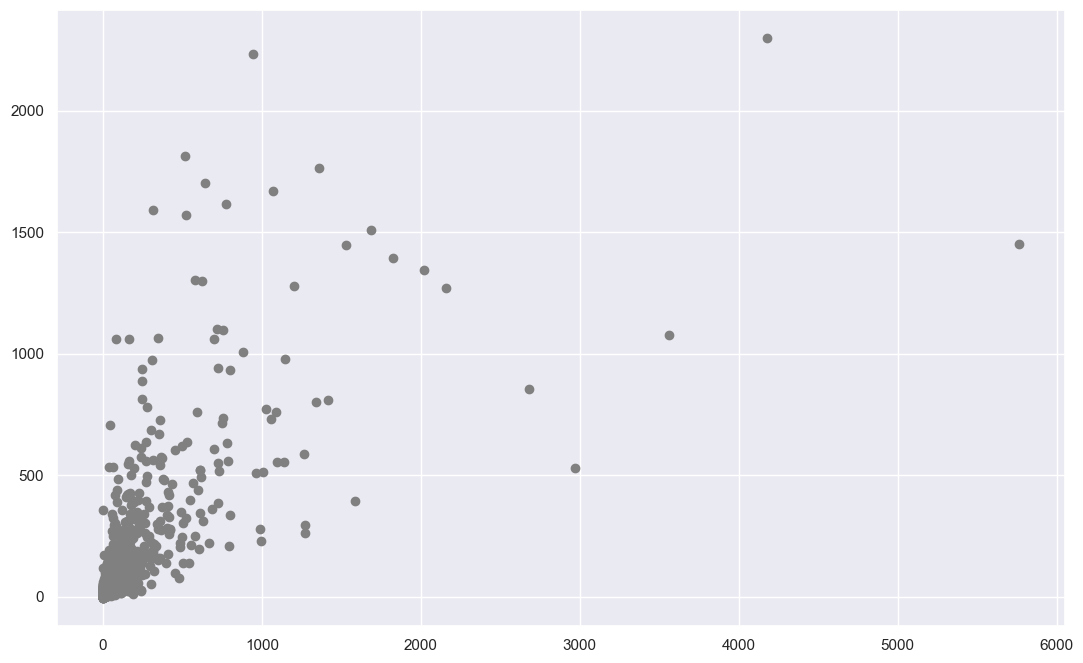

In [35]:
plt.figure(figsize=(13,8))
plt.scatter(y_test, cat_model.predict(X_test), color='gray')